In [1]:
import os

# BASE_PATH = '/gdrive/My Drive/colab_files/hw1/'
# BASE_PATH = 'C:\\Users\\alexm\\Desktop\\deep-learning-final-project\\temp'
BASE_PATH = r'C:\Users\Ian Hsiao\OneDrive - University of Washington\Courses\21au\DeepLearning\deep-learning-final-project'
# BASE_PATH = 'C:\\Users\\Jeffery\\Documents\\21au\\'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'pascal_voc\\'

# os.chdir('/content')

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import cv2
import copy
import sys
sys.path.append(BASE_PATH)
import pt_util
import img_util
import matplotlib.pyplot as plt

In [3]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

data_train = datasets.VOCSegmentation(root=DATA_PATH, year="2007", image_set='train', download=True, transform=transform_train)
data_test = datasets.VOCSegmentation(root=DATA_PATH, year="2007", image_set='test', download=True, transform=transform_test)

In [11]:
# this dataset wraps the voc dataset
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, sub_dataset):
        super(VOCDataset)
        self.sub_dataset = sub_dataset
    
    def __len__(self):
        return self.sub_dataset.__len__()
    
    def __getitem__(self, idx):
        data, label = self.sub_dataset.__getitem__(idx)
        return img_util.img_transpose(data).numpy(), img_util.to_RGB(label)

In [12]:
train_set = VOCDataset(data_train)

In [13]:
# here is how to get the first image
data, label = train_set.__getitem__(0)


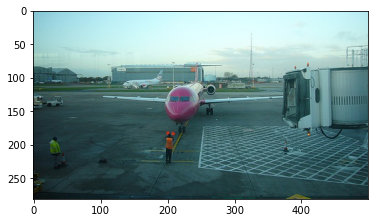

In [14]:
plt.imshow(data)

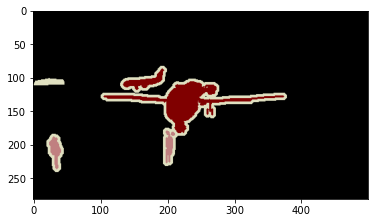

In [15]:
plt.imshow(label)

In [16]:
def blur_with_mask(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    image_copy = copy.deepcopy(image)

    #use mask and create another mask which makes background black and non-background white
    n, d, c = mask.shape
    for i in range(n):
        for j in range(d):
            for k in range(c):
                #224 is the color of the outline in the mask
                if mask[i][j][0] != 0 and mask[i][j][0] != 224:
                    image_copy[i][j][k] = 255
                else:
                    image_copy[i][j][k] = 0
    #blur original image
    #TODO: make kernel dynamic maybe and smooth mask
    blurred_original_image = cv2.GaussianBlur(image, (25,25) ,0)

    #apply the new mask to blured image to get unmasked part back
    layered_image = np.where(image_copy != (0,0,0), image, blurred_original_image)
    return layered_image

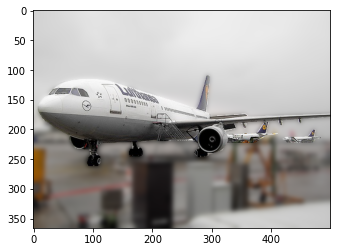

In [17]:
image, mask = train_set.__getitem__(1)
res = blur_with_mask(image, mask)
plt.imshow(res)


In [18]:
import cv2

cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    # frame is image
    image, mask = train_set.__getitem__(1)
    res = blur_with_mask(frame, mask)
#     plt.imshow(res)
    # do some ml here or something
    # show it
    cv2.imshow("test", res)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "photos/opencv_frame_{}.png".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

Escape hit, closing...
